## Creating new Charcaters using a Segmentation Model

In [1]:
#%pip install -U segmentation-models

In [1]:
import sys
sys.path.append('../')

In [47]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"

In [49]:
import segmentation_models as sm
import numpy as np
from src.data import datarenderer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import os

Segmentation Models: using `tf.keras` framework.


In [50]:
# Checking if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [51]:
BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)
charset_in = "A"
charset_out = "Ä"
img_size = 64
#num_glyphs = len(charset)
test_size = 0.1
batch_size = 16

In [113]:
path = os.path.join(os.pardir, "data", "processed", "filtered-fonts")
font_file_names = os.listdir(path)

np.random.seed(42)
font_file_names = np.random.permutation(font_file_names)
font_file_names = font_file_names#[:3_000]
font_file_paths = [os.path.join(path, font_file_name) for font_file_name in font_file_names]
num_samples = len(font_file_paths)
num_samples

23170

In [121]:
num_test_samples = int(num_samples * test_size)
x_train = datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=img_size, chars=charset_in, normalize=False).astype(np.float32)
y_train = datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=img_size, chars=charset_out, normalize=True, invert=False).astype(np.float32)
x_val = datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=img_size, chars=charset_in, normalize=False).astype(np.float32)
y_val = datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=img_size, chars=charset_out, normalize=True, invert=False).astype(np.float32)

In [122]:
# Preprocessing
# mapping glyph and background to two distinct arrays
# (sample_size, img_size, img_size, 2) --> (sample_size, img_size, img_size, 2)
# This means: we need the same array in (:,:,:,0) again in (:,:,:,1) but with inverted values

# y_train = np.stack((y_train, 1 - y_train), axis=-1)
# y_val = np.stack((y_val, 1 - y_val), axis=-1)
# This was giving the wrong shape (2700, 64, 64, 1, 2) instead of (2700, 64, 64, 2)
# Instead we do:
# y_train = np.squeeze(y_train, axis=-1)
# y_train = np.stack((y_train, 1 - y_train), axis=-1)
# y_val = np.squeeze(y_val, axis=-1)
# y_val = np.stack((y_val, 1 - y_val), axis=-1)

In [123]:
# preprocess input
#x_train = layers.Input(shape=(img_size, img_size, 1))(x_train)
x_train = np.squeeze(x_train, axis=-1)
x_train = np.stack((x_train, x_train, x_train), axis=-1)
#x_val = layers.Input(shape=(img_size, img_size, 1))(x_val)
x_val = np.squeeze(x_val, axis=-1)
x_val = np.stack((x_val, x_val, x_val), axis=-1)
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [125]:

# define model
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')

model = models.Sequential([
    #layers.Input(shape=(img_size, img_size, 1)),
    #layers.Conv2D(3, 1, activation='relu', padding='same'),  # Input layer
    base_model,
])

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, None, None, 1)     10115501  
                                                                 
Total params: 10115501 (38.59 MB)
Trainable params: 10071501 (38.42 MB)
Non-trainable params: 44000 (171.88 KB)
_________________________________________________________________


In [129]:
model.fit(
   x=x_train,
   y=y_train,
   batch_size=batch_size,
   epochs=1,
   validation_data=(x_val, y_val),
)

1304/1304 [==============================] - 110s 84ms/step - loss: 0.0844 - iou_score: 0.9714 - val_loss: 0.0833 - val_iou_score: 0.9725


In [130]:
def render_predictions(model, x_val, y_val, num_examples=4, figsize=(10, 10)):
    # function to plot the images: input, target and prediction
    if num_examples < 2:
        raise ValueError("num_examples must be at least 2")
    
    num_glyphs_x = x_val.shape[3]
    num_glyphs_y = y_val.shape[3]

    fig, axs = plt.subplots(num_examples, 
                            num_glyphs_x + num_glyphs_y*2, 
                            figsize=figsize)
    for idx in range(num_examples):
        input_img = x_val[idx, :, :, :]
        target_img = y_val[idx, :, :, :]
        prediction = model.predict(input_img[np.newaxis, :, :, :], verbose=0)
        for idx2 in range(num_glyphs_x):
            axs[idx, idx2].imshow(input_img[:, :, idx2], cmap="gray")
            axs[idx, idx2].set_xticks([])
            axs[idx, idx2].set_yticks([])
            axs[idx, idx2].set_title("Input")
        for idx2 in range(num_glyphs_y):
            axs[idx, num_glyphs_x + idx2].imshow(target_img[:, :, idx2], cmap="gray")
            axs[idx, num_glyphs_x + idx2].set_xticks([])
            axs[idx, num_glyphs_x + idx2].set_yticks([])
            axs[idx, num_glyphs_x + idx2].set_title("Target")
        for idx2 in range(num_glyphs_y):
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].imshow(prediction[0, :, :, idx2], cmap="gray")
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_xticks([])
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_yticks([])
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_title("Prediction")

    plt.show()

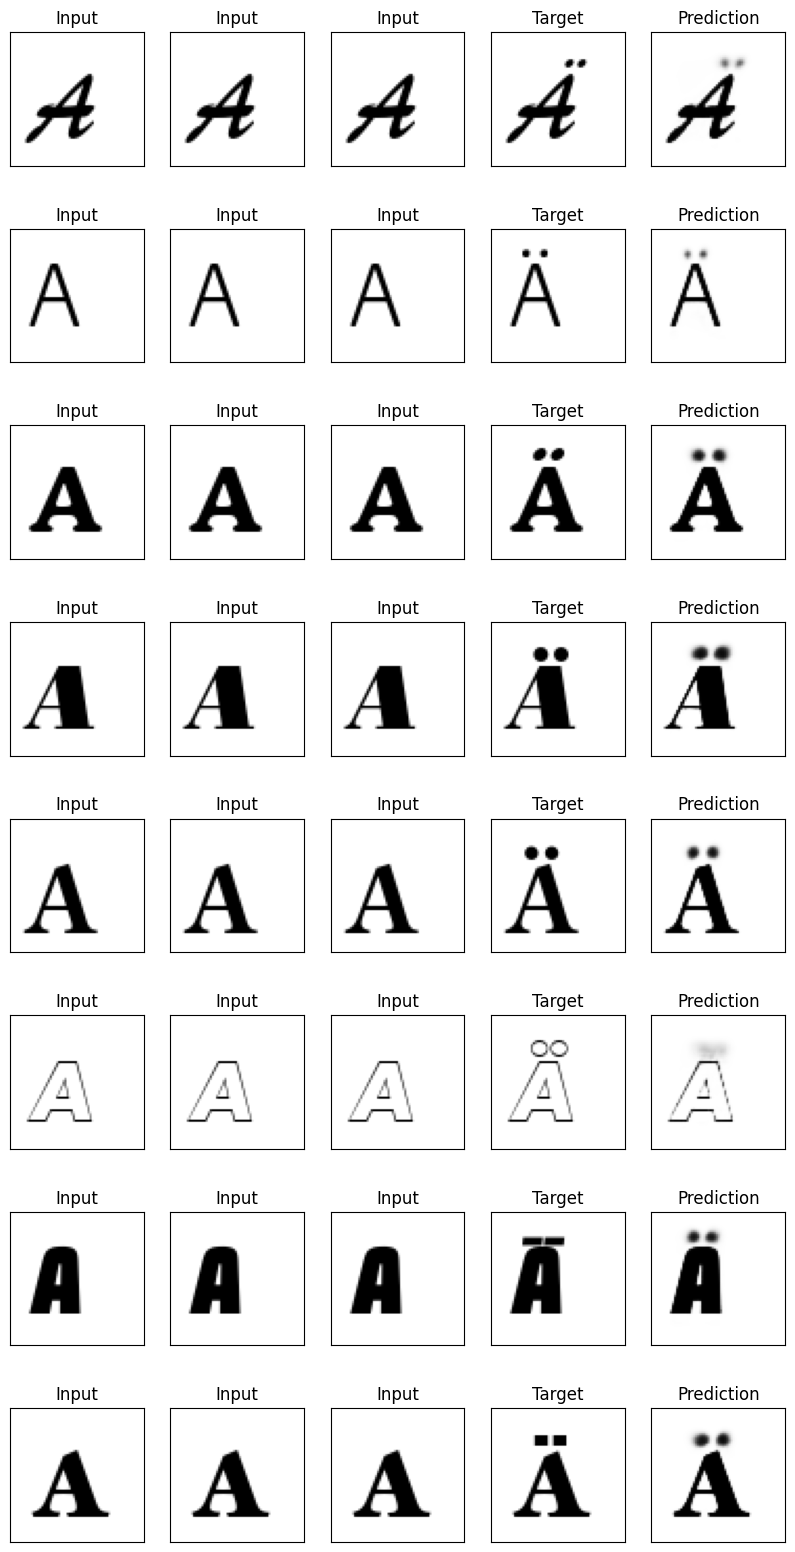

In [131]:
render_predictions(model, x_val, y_val, num_examples=8, figsize=(10, 20))

## Transfer Learning with EfficientNetB0 and Output Layer of the first Base Model

In [17]:
charset_in = "A"
charset_out = "Ä"
img_size = 64
#num_glyphs = len(charset)
test_size = 0.1
batch_size = 16

In [18]:
path = os.path.join(os.pardir, "data", "processed", "filtered-fonts")
font_file_names = os.listdir(path)

np.random.seed(42)
font_file_names = np.random.permutation(font_file_names)
font_file_names = font_file_names[:3_000]
font_file_paths = [os.path.join(path, font_file_name) for font_file_name in font_file_names]
num_samples = len(font_file_paths)
num_samples

3000

In [19]:
num_test_samples = int(num_samples * test_size)
x_train = datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=img_size, chars=charset_in, normalize=False).astype(np.float32)
y_train = datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=img_size, chars=charset_out, normalize=True, invert=False).astype(np.float32)
x_val = datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=img_size, chars=charset_in, normalize=False).astype(np.float32)
y_val = datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=img_size, chars=charset_out, normalize=True, invert=False).astype(np.float32)

In [20]:
print(x_train.shape)
print(y_train.shape)

(2700, 64, 64, 1)
(2700, 64, 64, 1)


In [41]:
# Load a pre-trained model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(img_size, img_size, 3), include_top=False)
base_model.trainable = False  # Freeze the base model

# Create custom layers
model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 1)),
    layers.Conv2D(3, 1, activation='relu', padding='same'),  # Input layer
    base_model,
    layers.Flatten(),
    #layers.Dense(512, activation="relu"),
    #layers.Dropout(0.1),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(img_size*img_size*len(charset_out), activation="sigmoid"),
    layers.Reshape((img_size, img_size, len(charset_out)))
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 3)         6         
                                                                 
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 flatten_6 (Flatten)         (None, 5120)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              5243904   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 4096)              4198400   
                                                      

In [42]:

# Train the model
model.fit(x_train, 
          y_train, 
          epochs=10, 
          validation_data=(x_val, y_val),
          batch_size=batch_size)


Epoch 1/10
169/169 [==============================] - 14s 58ms/step - loss: 0.1744 - val_loss: 0.1401
Epoch 2/10
169/169 [==============================] - 9s 53ms/step - loss: 0.1375 - val_loss: 0.1314
Epoch 3/10
169/169 [==============================] - 9s 50ms/step - loss: 0.1298 - val_loss: 0.1261
Epoch 4/10
169/169 [==============================] - 8s 50ms/step - loss: 0.1241 - val_loss: 0.1229
Epoch 5/10
169/169 [==============================] - 9s 53ms/step - loss: 0.1204 - val_loss: 0.1209
Epoch 6/10
169/169 [==============================] - 9s 54ms/step - loss: 0.1171 - val_loss: 0.1198
Epoch 7/10
169/169 [==============================] - 10s 58ms/step - loss: 0.1141 - val_loss: 0.1201
Epoch 8/10
169/169 [==============================] - 9s 51ms/step - loss: 0.1122 - val_loss: 0.1173
Epoch 9/10
169/169 [==============================] - 9s 52ms/step - loss: 0.1106 - val_loss: 0.1166
Epoch 10/10
169/169 [==============================] - 8s 50ms/step - loss: 0.1090 - val_

In [43]:
base_model.trainable = True  # Freeze the base model

In [44]:
model.fit(x_train, 
          y_train, 
          epochs=10, 
          validation_data=(x_val, y_val),
          batch_size=batch_size)

Epoch 1/10
169/169 [==============================] - 9s 51ms/step - loss: 0.1072 - val_loss: 0.1156
Epoch 2/10
169/169 [==============================] - 8s 49ms/step - loss: 0.1055 - val_loss: 0.1169
Epoch 3/10
169/169 [==============================] - 9s 51ms/step - loss: 0.1045 - val_loss: 0.1146
Epoch 4/10
169/169 [==============================] - 7s 42ms/step - loss: 0.1021 - val_loss: 0.1139
Epoch 5/10
169/169 [==============================] - 9s 52ms/step - loss: 0.1015 - val_loss: 0.1159
Epoch 6/10
169/169 [==============================] - 8s 49ms/step - loss: 0.1002 - val_loss: 0.1160
Epoch 7/10
169/169 [==============================] - 8s 49ms/step - loss: 0.0990 - val_loss: 0.1158
Epoch 8/10
169/169 [==============================] - 9s 52ms/step - loss: 0.0983 - val_loss: 0.1158
Epoch 9/10
169/169 [==============================] - 9s 55ms/step - loss: 0.0974 - val_loss: 0.1159
Epoch 10/10
169/169 [==============================] - 8s 49ms/step - loss: 0.0973 - val_lo

In [45]:
def render_predictions(model, x_val, y_val, num_examples=4, figsize=(10, 10)):
    # function to plot the images: input, target and prediction
    if num_examples < 2:
        raise ValueError("num_examples must be at least 2")
    
    num_glyphs_x = x_val.shape[3]
    num_glyphs_y = y_val.shape[3]

    fig, axs = plt.subplots(num_examples, 
                            num_glyphs_x + num_glyphs_y*2, 
                            figsize=figsize)
    for idx in range(num_examples):
        input_img = x_val[idx, :, :, :]
        target_img = y_val[idx, :, :, :]
        prediction = model.predict(input_img[np.newaxis, :, :, :], verbose=0)
        for idx2 in range(num_glyphs_x):
            axs[idx, idx2].imshow(input_img[:, :, idx2], cmap="gray")
            axs[idx, idx2].set_xticks([])
            axs[idx, idx2].set_yticks([])
            axs[idx, idx2].set_title("Input")
        for idx2 in range(num_glyphs_y):
            axs[idx, num_glyphs_x + idx2].imshow(target_img[:, :, idx2], cmap="gray")
            axs[idx, num_glyphs_x + idx2].set_xticks([])
            axs[idx, num_glyphs_x + idx2].set_yticks([])
            axs[idx, num_glyphs_x + idx2].set_title("Target")
        for idx2 in range(num_glyphs_y):
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].imshow(prediction[0, :, :, idx2], cmap="gray")
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_xticks([])
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_yticks([])
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_title("Prediction")

    plt.show()

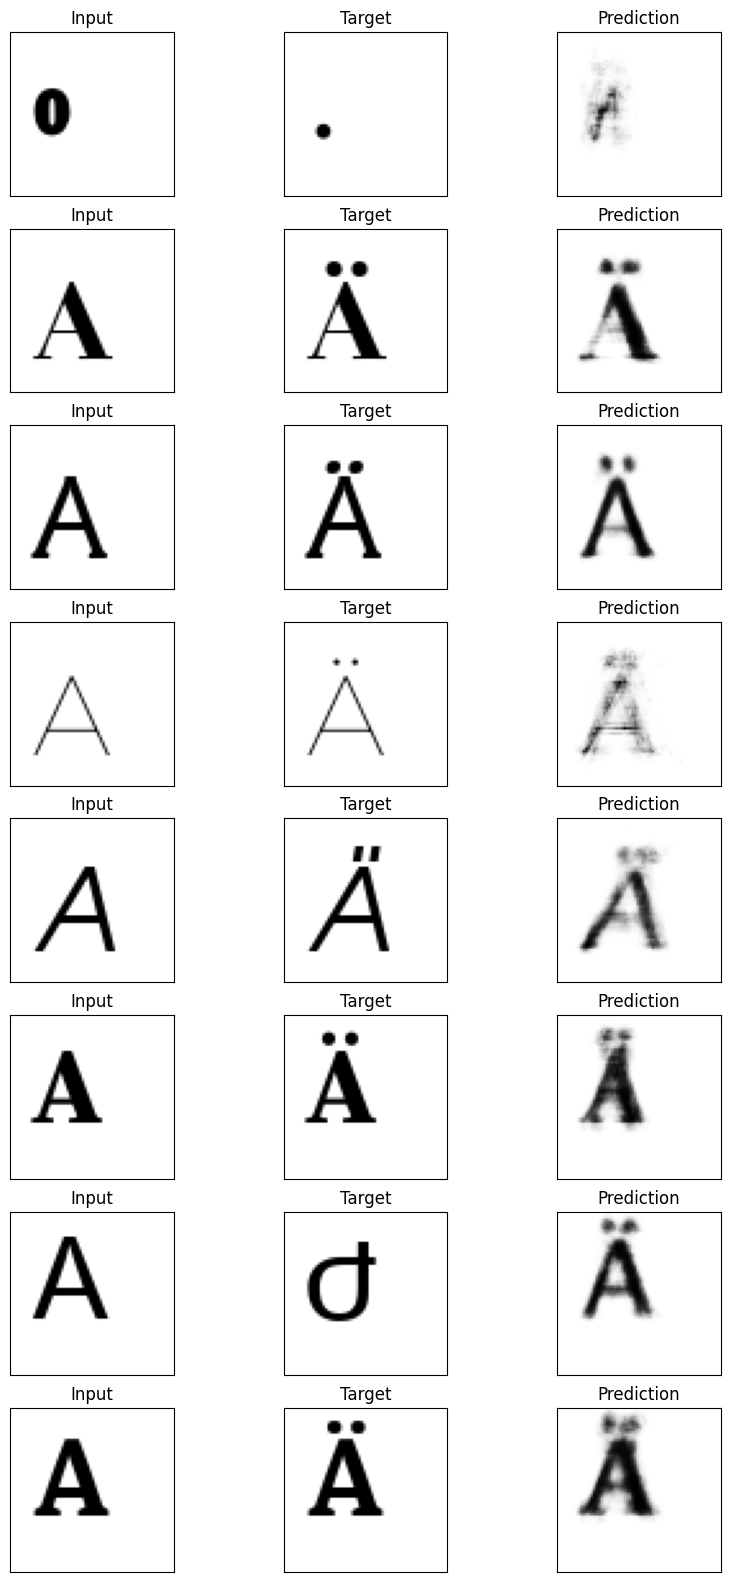

In [46]:
render_predictions(model, x_val, y_val, num_examples=8, figsize=(10, 20))